In [ ]:
!pip install discretize==0.10.0 #differ from the 0.8.3
!pip install SimPEG==0.19
!pip install pymatsolver==0.2.0
!pip install utm==0.7.0

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from datfiles_lib_parallel import *
from os import listdir
import torch.optim as optim

In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile
import utm
from discretize import TreeMesh, TensorMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG.utils import model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

mpl.rcParams.update({"font.size": 16})
# sphinx_gallery_thumbnail_number = 4

In [4]:
from matplotlib.colors import Colormap
import pymatsolver
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    apparent_resistivity_from_voltage,
    plot_pseudosection,
)

Define the topology

In [5]:
x_topo, y_topo = np.meshgrid(
    np.linspace(-2000, 2000, 401), np.linspace(-2000, 2000, 62)
)

z_topo = np.zeros(x_topo.shape)
x_topo, y_topo, z_topo = mkvc(x_topo), mkvc(y_topo), mkvc(z_topo)
topo_xyz = np.c_[x_topo, y_topo, z_topo]

topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

Define the survey configuration

In [6]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = np.r_[-350.0, 350.0]
station_separation = 25.0
num_rx_per_src = 24 #With Tx fixed, move Rx 24 times

# Generate source list for DC survey line
source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

# Define survey
survey = dc.survey.Survey(source_list, survey_type=survey_type)

Mesh Design

In [7]:
# Cell sizes
csx, csy = 5.0, 5.0
# Number of core cells in each direction
ncx, ncy = 200.0 , 25.0
# Number of padding cells to add in each direction
npad = 7
# Vectors of cell lengths in each direction with padding
hx_ = [(csx, npad, -1.5), (csx, ncx), (csx, npad, 1.5)]
hy_ = [(csy, npad, -1.5), (csy, ncy)]
# Create mesh and center it
mesh = TensorMesh([hx_, hy_], x0="CN")


In [8]:
mesh

TensorMesh: 6,848 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    214       -741.29        741.29      5.00     85.43    1.50
   y     32       -366.29          0.00      5.00     85.43    1.50

<ipython-input-9-b87a06acbe67>:1: FutureWarning: TensorMesh.plotGrid has been deprecated, please use TensorMesh.plot_grid. It will be removed in version 1.0.0 of discretize.
  mesh.plotGrid()


<Axes: xlabel='x1', ylabel='x2'>

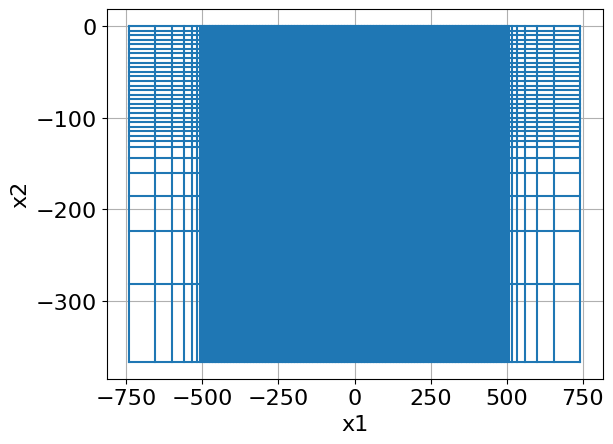

In [9]:
mesh.plotGrid()

Define the true conductivity model

Case 1.1

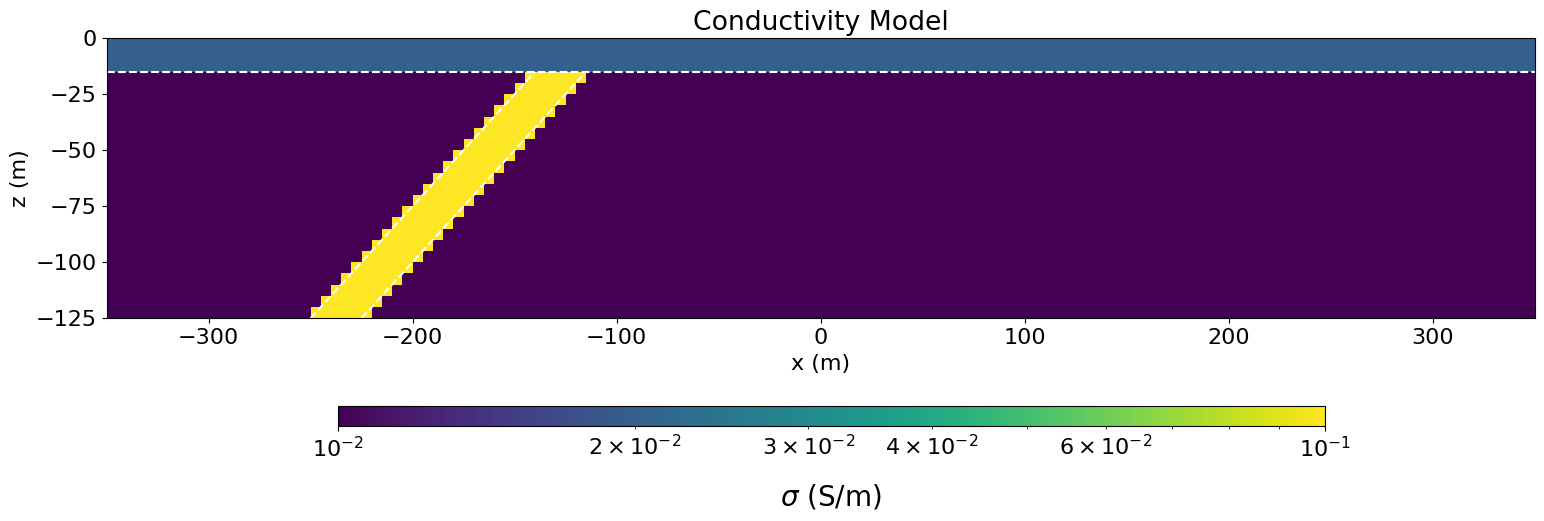

In [10]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&
    (mesh.gridCC[:, 1] >=  (mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= (mesh.gridCC[:, 0]+125))
)

conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 1.2

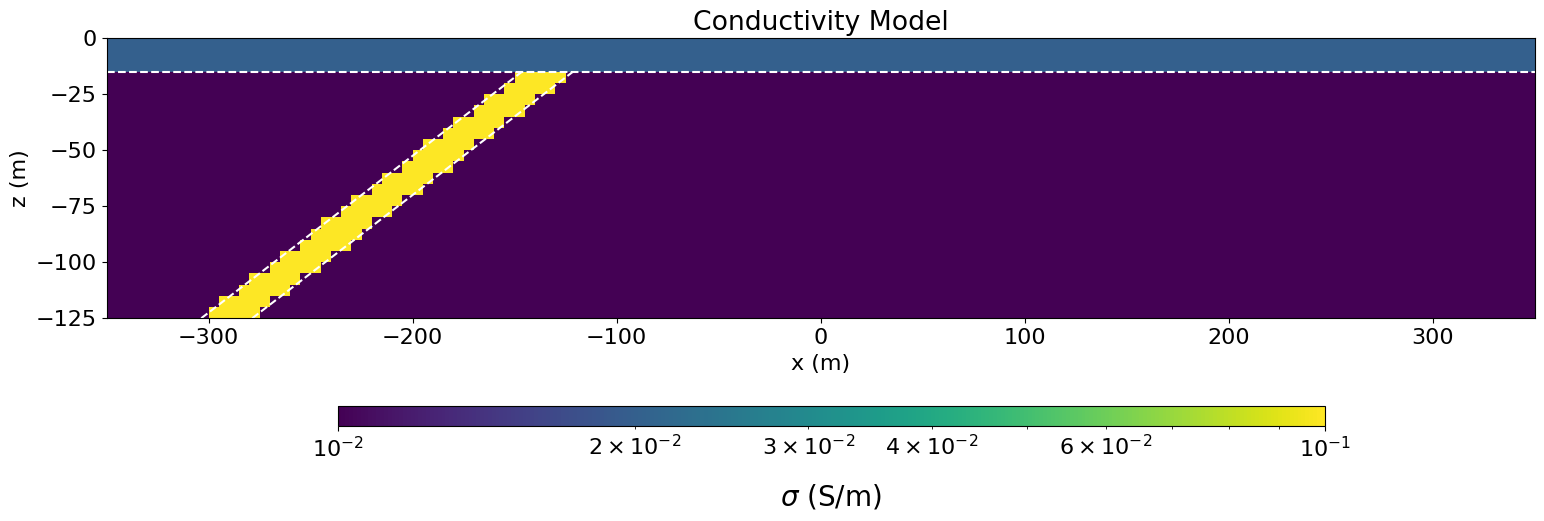

In [ ]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&
    (mesh.gridCC[:, 1] >=  .7*(mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= .7*(mesh.gridCC[:, 0]+125))
)
conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/.7-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/.7-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 1.3

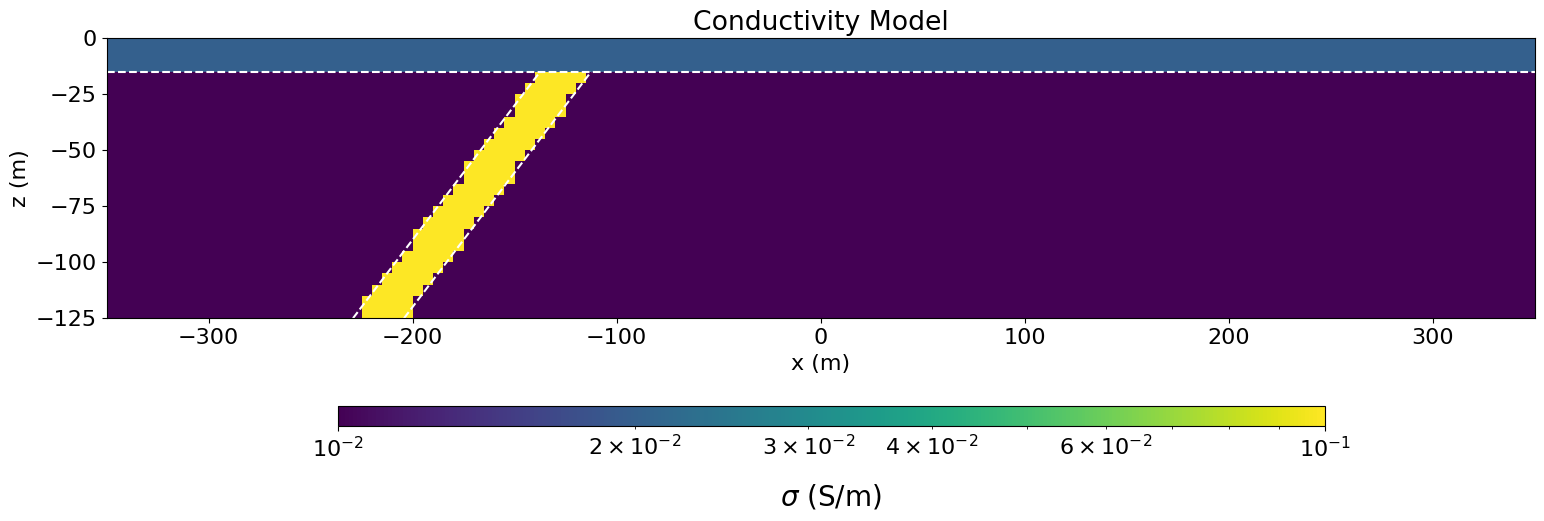

In [ ]:
# Define conductivity model in S/m

background_conductivity = 1e-2
layer_1 = 2e-2
dike_ = 1e-1

# Find active cells in forward modeling (cell below surface)
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])

# Define mapping from model to active cells
nC = int(ind_active.sum()) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

xlim_layer_1 = np.r_[-740, 740]
zlim_layer_1 = np.r_[-15, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())
)

conductivity_model[layer1] = layer_1

dike = ((mesh.gridCC[:, 1] <=-15)&
    (mesh.gridCC[:, 1] >=  1.2*(mesh.gridCC[:, 0]+100)) & (mesh.gridCC[:, 1] <= 1.2*(mesh.gridCC[:, 0]+125))
)

conductivity_model[dike] = dike_
# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)
ax1.plot(np.linspace(-350,350, 1000), -15*np.ones(1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/1.2-125, np.linspace(-125,-15, 1000), "w--")
ax1.plot(np.linspace(-125,-15, 1000)/1.2-100, np.linspace(-125,-15, 1000), "w--")
ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 2.1

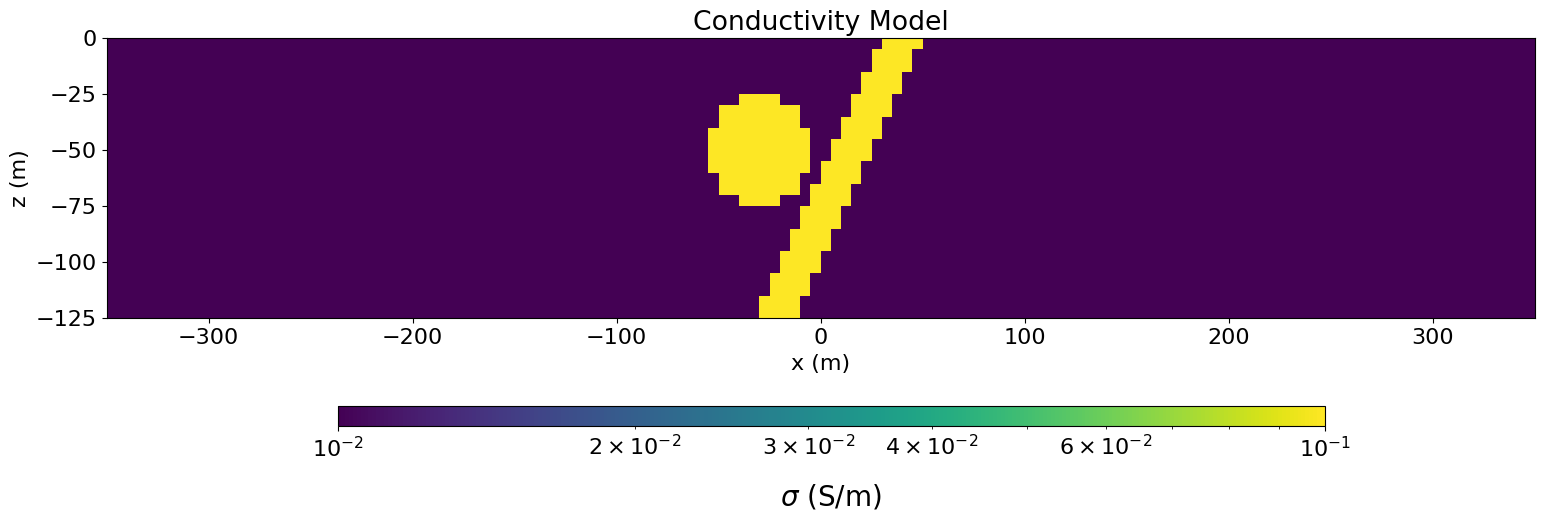

In [ ]:
background_conductivity = 1e-2
conductor_conductivity = 1e-1
conductor_sphere = 1e-1
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])
# Define mapping from model to active cells
nC = int(mesh.nC) # Number of cells below the surface <= ind_active.shape[0]

# Define model
conductivity_model = background_conductivity * np.ones(nC)

ind_conductor = model_builder.getIndicesSphere(np.r_[-30.0, -50.0], 25.0, mesh.gridCC)
ind_conductor = ind_conductor[ind_active]
conductivity_model[ind_conductor] = conductor_sphere


xlim_layer_1 = np.r_[-120, 70]
zlim_layer_1 = np.r_[-150, 0]

layer1 = (
    (mesh.gridCC[:, 0] >= xlim_layer_1.min()) & (mesh.gridCC[:, 0] <= xlim_layer_1.max()) &
    (mesh.gridCC[:, 1] >= zlim_layer_1.min()) & (mesh.gridCC[:, 1] <= zlim_layer_1.max())&(mesh.gridCC[:, 1] <=  2.*(mesh.gridCC[:, 0]-30))
    &(mesh.gridCC[:, 1] >=  2.*(mesh.gridCC[:, 0]-50)))

conductivity_model[layer1] = conductor_conductivity

# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)

ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

Case 2.2

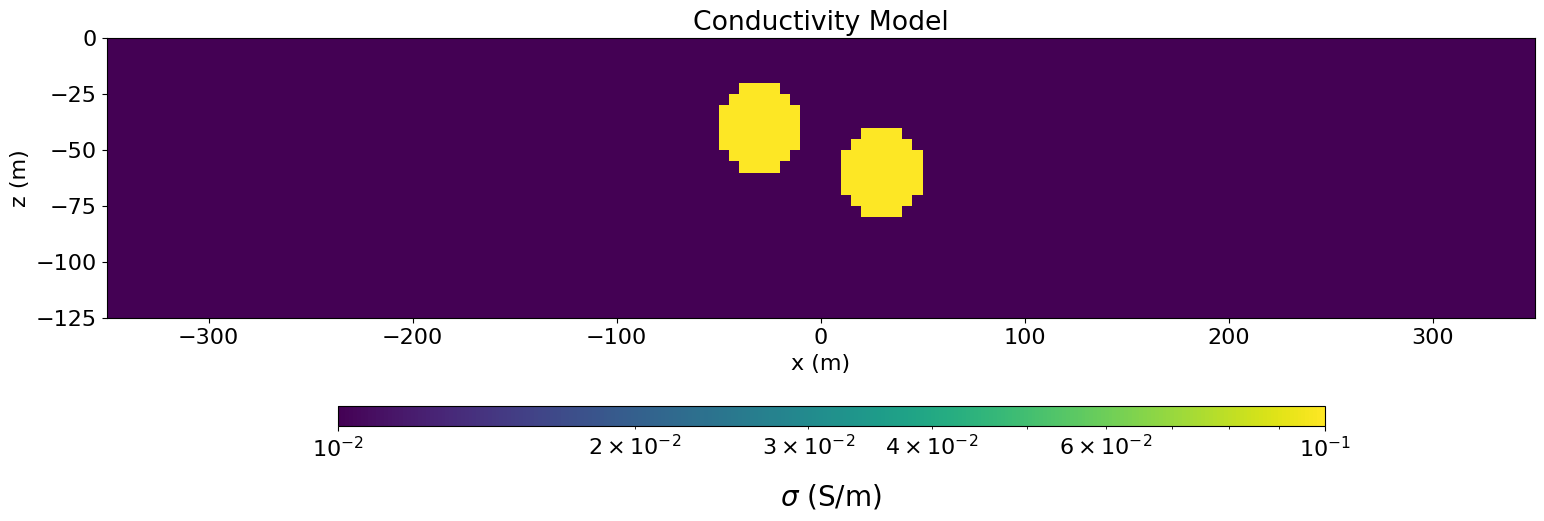

In [ ]:
background_conductivity = 1e-2
conductor_conductivity = 1e-1
conductor_sphere = 1e-1
ind_active = active_from_xyz(mesh, topo_xyz[:, [0, 2]])
# Define mapping from model to active cells
nC = int(mesh.nC) # Number of cells below the surface <= ind_active.shape[0]
# conductivity_map = maps.InjectActiveCells(mesh, ind_active, air_conductivity)

# Define model
conductivity_model = background_conductivity * np.ones(nC)

ind_conductor = model_builder.getIndicesSphere(np.r_[-30.0, -40.0], 20.0, mesh.gridCC)
ind_conductor = ind_conductor[ind_active]
conductivity_model[ind_conductor] = conductor_sphere


ind_conductor = model_builder.getIndicesSphere(np.r_[30.0, -60.0], 20.0, mesh.gridCC)
ind_conductor = ind_conductor[ind_active]
conductivity_model[ind_conductor] = conductor_sphere

# Plot Conductivity Model
fig = plt.figure(figsize=(21, 4))

plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)
norm = LogNorm(vmin=1e-2, vmax=1e-1)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-350, 350)
ax1.set_ylim(-125, 0)

ax1.set_title("Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.25, -.1, 0.47, 0.05])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="horizontal")
cbar.set_label("$\sigma$ (S/m)", labelpad=15, size=20)

plt.show()

In [11]:
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=maps.IdentityMap(mesh), solver=Solver
)

# Predict the data by running the simulation. The data are the raw voltage in
# units of volts.
dpred = simulation.dpred(conductivity_model)

/usr/local/lib/python3.10/dist-packages/SimPEG/utils/solver_utils.py:89: UserWarning: is_symmetric is not a valid keyword for splu and will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/SimPEG/utils/solver_utils.py:89: UserWarning: is_positive_definite is not a valid keyword for splu and will be ignored
  warnings.warn(


Store toplogy and measurements to the topo_xyz.txt and dc_data.obs respectively.

In [12]:
write_output = True

In [13]:
dir_path = 'dcr2d_voltages'
os.mkdir(dir_path)

In [14]:
if write_output:
    dir_path = 'dcr2d_voltages'

    # Add 5% Gaussian noise to each datum for Case1.X and Case2.X
    np.random.seed(225)
    std = 0.05 * np.abs(dpred)
    dc_noise = std * np.random.randn(len(dpred))
    dobs = dpred + dc_noise

    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_xyz,
        num_rx_per_src,
        station_separation,
    )
    survey_original = dc.survey.Survey(source_list)

    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "/dc_data.obs"
    write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    fname = dir_path + "/topo_xyz.txt"
    np.savetxt(fname, topo_xyz, fmt="%.4e")

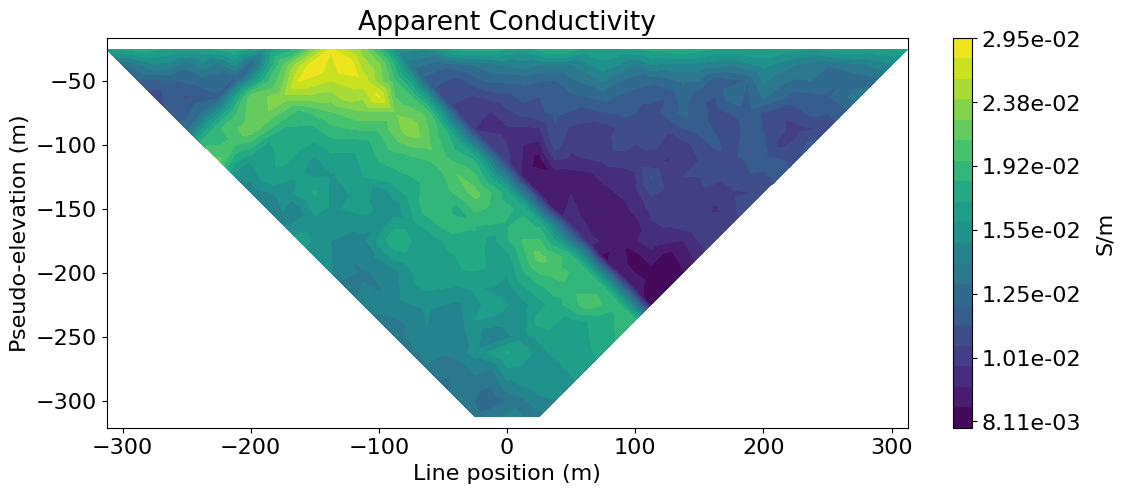

In [15]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    data_obj,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    data_type="apparent conductivity",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")
plt.show()